# Import libraries



In [1]:
options(warn=-1)
install.packages("lsa")
install.packages("tm")
install.packages("RWeka")
install.packages("Metrics")

library(tm)
library(lsa)
library(RWeka)
library(Metrics)
library(purrr)
library(Matrix)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘SnowballC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘NLP’, ‘Rcpp’, ‘slam’, ‘BH’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RWekajars’, ‘rJava’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: NLP

Loading required package: SnowballC



# Download datasets

In [2]:
df_doc <- read.csv('https://raw.githubusercontent.com/Anna-8/Information-Retrieval/main/doc.csv')
head(df_doc, 2)

,index,document,title
,<int>,<chr>,<chr>
1,1,"Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification. The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed. In spite of the DDC's long and healthy life, however, its full story has never been told. There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad.",18 Editions of the Dewey Decimal Classifications
2,2,"Slater, M. This report is an analysis of 6300 acts of use in 104 technical libraries in the United Kingdom. Library use is only one aspect of the wider pattern of information use. Information transfer in libraries is restricted to the use of documents. It takes no account of documents used outside the library, still less of information transferred orally from person to person. The library acts as a channel in only a proportion of the situations in which information is transferred. Taking technical information transfer as a whole, there is no doubt that this proportion is not the major one. There are users of technical information - particularly in technology rather than science - who visit libraries rarely if at all, relying on desk collections of handbooks, current periodicals and personal contact with their colleagues and with people in other organizations. Even regular library users also receive information in other ways.",Use Made of Technical Libraries


In [3]:
df_qry <- read.csv('https://raw.githubusercontent.com/Anna-8/Information-Retrieval/main/qry.csv')
head(df_qry, 2)

,index,query
,<int>,<chr>
1,1,What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?
2,2,"How can actually pertinent data, as opposed to references or entire articles themselves, be retrieved automatically in response to information requests?"


In [4]:
df_rel <- read.csv('https://raw.githubusercontent.com/Anna-8/Information-Retrieval/main/rel.csv')
head(df_rel, 2)

,qry_id,rel_doc
,<int>,<int>
1,1,28
2,1,35


In [5]:
cat("Number of docs:",nrow(df_doc))
cat("\nNumber of queries:",nrow(df_qry) )

Number of docs: 1460
Number of queries: 76

# Data preparation

### Create the corpus

In [6]:
docs = df_doc$document
corpus <- Corpus(VectorSource(docs))
inspect(corpus[1:3])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 3

[1] Comaromi, J.P. The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad.                                                                                                                                                                                                                                                                                                                                                          

### Normalize docs

In [7]:
corpus <- tm_map( corpus, tolower )
corpus <- tm_map( corpus, removePunctuation )
corpus <- tm_map( corpus, removeWords, stopwords())
inspect(corpus[1:3])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 3

[1] comaromi jp  present study   history   dewey decimal classification   first edition   ddc  published  1876  eighteenth edition  1971  future editions will continue  appear  needed   spite   ddcs long  healthy life however  full story  never  told     biographies  dewey  briefly describe  system     first attempt  provide  detailed history   work       spurred  growth  librarianship   country  abroad                                                                                                                                                                                                                                                                                                                                                            
[2] slater m  report   analysis  6300 acts  use  104 technical libraries   united kingdom library use   one aspect   wider pattern  information u

###Create the terms-docs matrix

In [8]:
tdm <- TermDocumentMatrix(corpus)
inspect( tdm )

<<TermDocumentMatrix (terms: 11619, documents: 1460)>>
Non-/sparse entries: 80850/16882890
Sparsity           : 100%
Maximal term length: 42
Weighting          : term frequency (tf)
Sample             :
             Docs
Terms         1090 1091 126 1407 1415 1417 1418 17 400 820
  data           2    7   1    3    1    1    5  0   2   0
  information    0    0   8    7    0    0    0  1   4   2
  libraries      0    0   0    0    0    2    6  4   0   0
  library        4    0   2    0    4    1    7  5   0   0
  one            2    3   1    1    4    1    1  1   1   1
  research       0    0   0    0    0    0    1  3   1   0
  retrieval      0    0   2    0    0    0    0  0   0   0
  system         0    1   2    0    1    1    3  0   1   0
  systems        0    0   1    0    0    0    6  2   0   2
  use            2    0   2    4    1    1    3  0   0   0


In [9]:
#partially remove sparsity from the terms-docs matrix
tdm <- removeSparseTerms( tdm, 0.997 )
inspect( tdm)

<<TermDocumentMatrix (terms: 2935, documents: 1460)>>
Non-/sparse entries: 67362/4217738
Sparsity           : 98%
Maximal term length: 19
Weighting          : term frequency (tf)
Sample             :
             Docs
Terms         1090 1091 126 1407 1415 1417 1418 17 400 820
  data           2    7   1    3    1    1    5  0   2   0
  information    0    0   8    7    0    0    0  1   4   2
  libraries      0    0   0    0    0    2    6  4   0   0
  library        4    0   2    0    4    1    7  5   0   0
  one            2    3   1    1    4    1    1  1   1   1
  research       0    0   0    0    0    0    1  3   1   0
  retrieval      0    0   2    0    0    0    0  0   0   0
  system         0    1   2    0    1    1    3  0   1   0
  systems        0    0   1    0    0    0    6  2   0   2
  use            2    0   2    4    1    1    3  0   0   0


In [10]:
cat("Rank of the terms-docs matrix:",rankMatrix(tdm))

Rank of the terms-docs matrix: 1458

In [11]:
#store terms
words <- rownames(tdm)
#convert a data.table into a matrix
tdm <- as.matrix(tdm)
head(tdm)

,1,2,3,4,5,6,7,8,9,10,⋯,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
1971,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
abroad,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
appear,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
attempt,1,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
briefly,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
classification,1,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


# Tf-idf Analysis

In [12]:
#computes the weighted term docs matrix according to tf-idf statistics
tdm <- lw_logtf(tdm) * ( 1-entropy(tdm) )  
head(tdm)

,1,2,3,4,5,6,7,8,9,10,⋯,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
1971,0.4038779,0,0,0,0,0,0.0000000,0,0.0000000,0,⋯,0,0,0,0,0,0,0.0000000,0,0,0
abroad,0.5400388,0,0,0,0,0,0.0000000,0,0.0000000,0,⋯,0,0,0,0,0,0,0.0000000,0,0,0
appear,0.3739818,0,0,0,0,0,0.0000000,0,0.0000000,0,⋯,0,0,0,0,0,0,0.0000000,0,0,0
attempt,0.2863633,0,0,0,0,0,0.2863633,0,0.0000000,0,⋯,0,0,0,0,0,0,0.2863633,0,0,0
briefly,0.3586892,0,0,0,0,0,0.0000000,0,0.0000000,0,⋯,0,0,0,0,0,0,0.0000000,0,0,0
classification,0.2843447,0,0,0,0,0,0.0000000,0,0.2843447,0,⋯,0,0,0,0,0,0,0.0000000,0,0,0


### Evaluation of a query


In [13]:
# define the function to compute the cosine similarity between a vector Q and a matrix X
cosines <- function(X, Q) apply(X, 1, cosine, as.vector(Q))
# define an "argmax" function that return the indices of the highest N values in a matrix X
top <- function(X, N) order( X, decreasing=TRUE )[1:N]

In [14]:
# select a query example to retrieve the most relevant docs according to the LSA space
qry_id = 1
query_example <- df_qry[df_qry$index== qry_id,]$query
query_example
# compute the query vector (based on the given vocabulary) as matrix

[1] "What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?"

In [15]:
# transform the query in a doc vector
q <- query( query_example, words )
# weight the query  with tf-idf
q_k <- lw_logtf(q) * ( 1-entropy(tdm) )
cat("Size of the transformed query:", dim(q_k))

Size of the transformed query: 2935 1

In [16]:
#compute the binary vector that contains 1 if the doc has been retrieved as relevant, zero otherwise
predicted <- rep(0, 1460)
#find the first k retrieved docs
retrieved_docs = top(cosines(t(tdm), t(q_k)), 20)
#convert list in a binary vector
predicted[retrieved_docs] <- 1
#compute the ground truth binary vector 
actual <- rep(0, 1460)
#find the first k relevant docs
relevant_docs= df_rel[df_rel$qry_id== qry_id,]$rel_doc
actual[relevant_docs] <- 1

In [17]:
#first relevant doc for the query example
df_doc[df_doc$index== relevant_docs[1],]$document

[1] "Taube, M. Recently a number of articles, books, and reports dealing with information systems, i.e., document retrieval systems, have advanced the doctrine that such systems are to be evaluated in terms of the degree or percentage of relevancy they provide. Although there seems to be little agreement on what relevance means, and some doubt that it is quantifiable, there is, nevertheless, a growing agreement that a fixed and formal relationship exists between the relevance and the recall performance of any system.  Thus, we will find in the literature both a frankly subjective notion of relevance as reported by individual users, and equations, curves, and mathematical formulations which presumably provide numerical measures of the recall and relevance characteristics of information systems.  This phenomenon of shifting back and forth from an admittedly subjective and non-mathematical term to equations in which the same term is given a mathematical value or a mathematical definition has its ancient parallel in discussions of probability.  One cannot, of course, legislate the meaning of a term.  It all depends, as Alice pointed out, on \"who is master,\" the user or the term.  On the other hand, the use of a single term in the same document to cover two or more distinct meanings, especially when such a usage is designed to secure the acceptance of a doctrine by attributing to it mathematical validity which it does not have, represents a more serious situation than merely careless ambiguity. "

In [18]:
#first retrieved doc for the query example
df_doc[df_doc$index== retrieved_docs[1],]$document

[1] "Bottle, R.R. Seeley, C.R. Some methods of estimating the minimum amounts of information in a document not retrievable through its title are discussed.  An analysis of the information transferred by different types of keywords is helpful in planning search strategies, e.g., 30% of chemical substances mentioned in journal articles are not discernable in their titles even when broad class names are used as synonyms.  Patents have considerably less informative titles than journal articles.  In nuclear science, report titles are also less informative than those of journal articles, but the proportion of reports with completely uninformative titles is now only 10% of the 1957 value.  Titles in chemistry are more informative than those in most other fields, but the use of alerting and other services based on titles requires a good understanding of the underlying information transfer principles. "

### Evaluation functions


We consider different kinds of metrics to evaluate the performance of the model. Let's call $TP/FP$ the number of true/false positives and $TN/FN$ the number of true/false negatives. We define:

*   **Precision**: $ P= \frac{TP}{TP+FP}$

*   **Recall**: $ R= \frac{TP}{TP+FN}$

*   **f1-score**: $ F_1 = 2\frac{P\cdot R}{P+R}$

*   **Mean Average Precision**: $MAP = \frac{1}{|Q|}∑_{j=1}^{|Q|} \frac{1}{m_j}\sum_{k=1}^{m_j}Precision(R_{jk})$

* **R-Precision**: Let R be the number of docs relevant for a given query, the R-precision is the number of docs relevant in the first R doc retrived divided by R.

The precision and the recall will be computed according to the package Metrics (https://cran.r-project.org/web/packages/Metrics/Metrics.pdf).

In [19]:
#compute the f1 score
f1 <- function(actual, predicted){
  prec = precision(actual, predicted)
  rec = recall(actual, predicted)
  if (prec+rec>0){
    return (2*prec*rec/(prec+rec))
    }
  return (1)
}

# compute the mean Average precision
# takes in input the query ids and the results (for each query the first k retrived docs )
MAP <- function(qry_ids, results){
  map = c()
  for (index in 1:length(qry_ids)){
      gt_docs <- df_rel[df_rel["qry_id"]==qry_ids[index],]$rel_doc
      r <- length(gt_docs)
      r_precision <- c()
      for (k in 1:r){
          r_precision <- append(x = r_precision, values = length(intersect(results[index][1:k],gt_docs))/k) #doppia quadra in results?
      }
      map <- append(map, sum(r_precision) / r)
  }
  return (sum(map) / length(qry_ids))
}


queries_precision <- function(qry_ids, results){
  precisions = c()
  for (i in 1:length(qry_ids)){
    # create the ground truth binary vector that contains 1 at position k if the k docs is relevant for the query q
    actual <- rep(0, 1460)
    actual[df_rel[df_rel$qry_id== qry_ids[i],]$rel_doc] <- 1
    # create the predict truth binary vector that contains 1 at position k if the k docs is relevant for the query q
    predicted <- rep(0, 1460)
    predicted[results[i,]] <- 1
    precisions <- append(precisions, precision(actual, predicted) )
  }
  return (precisions)
}

queries_recall <- function(qry_ids, results){
  recalls = c()
  for (i in 1:length(qry_ids)){
    # create the ground truth binary vector that contains 1 at position k if the k docs is relevant for the query q
    actual <- rep(0, 1460)
    actual[df_rel[df_rel$qry_id== qry_ids[i],]$rel_doc] <- 1
    # create the predict truth binary vector that contains 1 at position k if the k docs is relevant for the query q
    predicted <- rep(0, 1460)
    predicted[results[i,]] <- 1
    recalls <- append(recalls, recall(actual, predicted) )
  }
  return (recalls)
}

#compute the f1 scores for all the queries
queries_scores <- function(qry_ids, results){
  scores = c()
  for (i in 1:length(qry_ids)){
    # create the ground truth binary vector that contains 1 at position k if the k docs is relevant for the query q
    actual <- rep(0, 1460)
    actual[df_rel[df_rel$qry_id== qry_ids[i],]$rel_doc] <- 1
    # create the predict truth binary vector that contains 1 at position k if the k docs is relevant for the query q
    predicted <- rep(0, 1460)
    predicted[results[i,]] <- 1
    scores <- append(scores, f1(actual, predicted) )
  }
  return (scores)
}

#for a given query compute the first k top results
top_results <- function(qry_id, df_qry, tdm, k){
  query_example <- df_qry[df_qry$index== qry_id,]$query
  q <- query( query_example, words )
  q_k <- lw_logtf(q) * ( 1-entropy(tdm) )
  return (top(cosines(t(tdm), q_k), k))
}


## Evalutation of the results 

In [20]:
k =10
# the row i of the matrix results contains the first k retrieved docs for the query i
results = t(sapply(df_qry$index, top_results, df_qry, tdm, k))
#example of retrived docs for the first query
cat("First k retrieved docs for the first query:", results[1,],"\n")
cat("First k relevant  docs for the first query:", df_rel[df_rel$qry_id== 1,]$rel_doc[1:k])

First k retrieved docs for the first query: 722 1281 814 1299 447 429 790 676 477 449 
First k relevant  docs for the first query: 28 35 38 42 43 52 65 76 86 150

In [21]:
# compute the mean precision for all the queries
precisions = queries_precision(df_qry$index, results)
cat("Mean precision:", mean(precisions))

Mean precision: 0.2973684

In [22]:
# compute the mean recall for all the queries
recalls = queries_recall(df_qry$index, results)
cat("Mean recall:", mean(recalls))

Mean recall: 0.1236963

In [23]:
# compute the mean f1 score for all the queries
scores = queries_scores(df_qry$index, results)
cat("Mean f1 score:", mean(scores))

Mean f1 score: 0.2746364

In [24]:
#compute the mean average precision
cat("MAP:", MAP(df_qry$index, results))

MAP: 0.05917901

# Latent Semantic Analysis

We perform the Latent Semantic Analysis through the package LSA (https://cran.r-project.org/web/packages/lsa/lsa.pdf)

### Define the Latent Space

In [38]:
# create the latent semantic space from the terms docs matrix
lsar <- lsa(tdm) 
# compute the number of eigenvalues
n = length(lsar$sk)
cat("n:",n)

n: 426

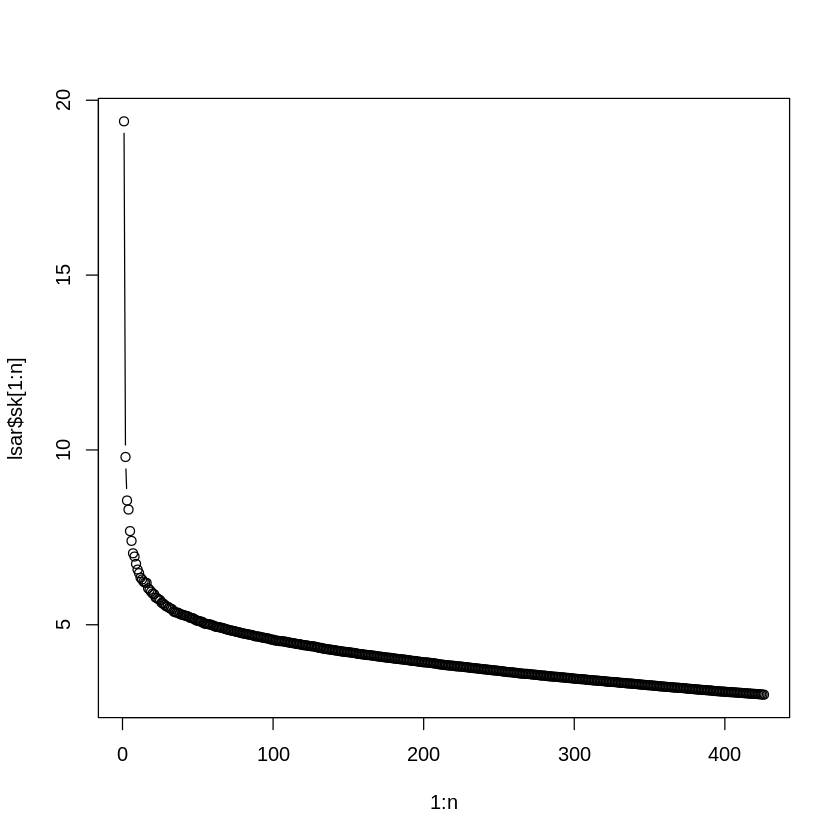

In [28]:
# plot the eigenvalues
plot(1:n, lsar$sk[1:n], type="b" )

In [29]:
# compute the terms matrix and weight it by the eigenvalues 
tkw <- lsar$tk %*% diag( lsar$sk )
# compute the docs matrix and weight it by the eigenvalues 
dkw <- lsar$dk %*% diag( lsar$sk )
# dimensions 
cat("Dimnension of the term matrix:", dim(tkw), "\n")
cat("Dimnension of the docs matrix:", dim(dkw))

Dimnension of the term matrix: 2935 426 
Dimnension of the docs matrix: 1460 426

Representation of terms in the Latent Semantic Space 




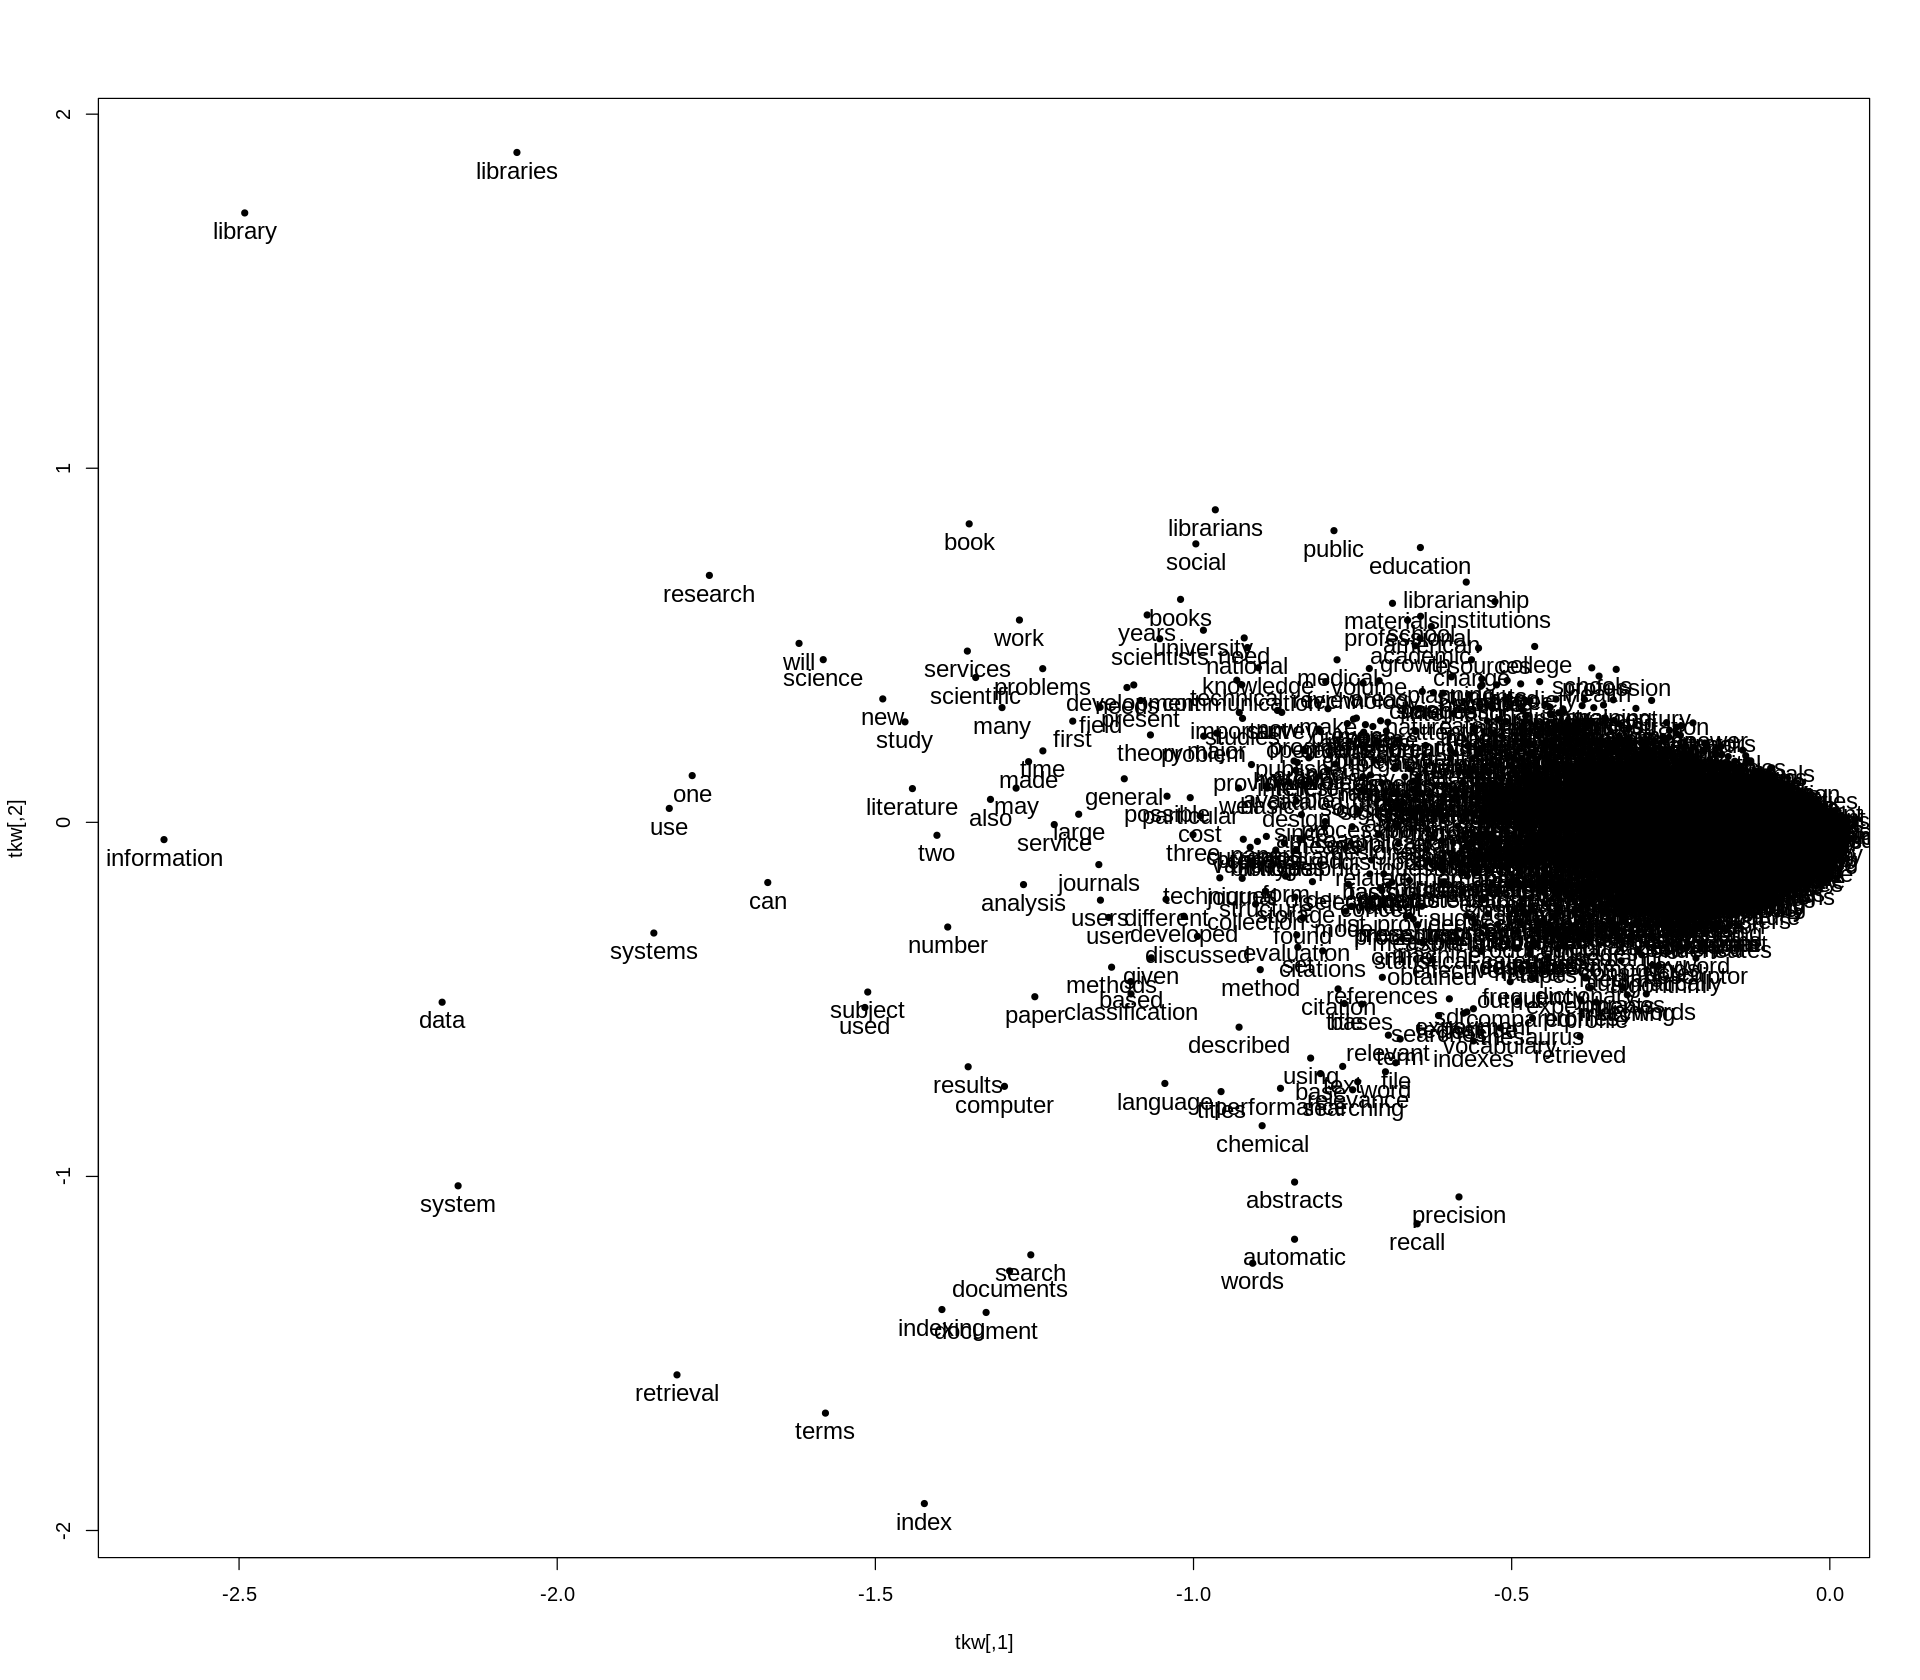

In [30]:
# graphic representation of terms using the first two latent dimensions
options(repr.plot.width=16, repr.plot.height=14)
plot( tkw, pch=20 )
text( tkw, labels=words, cex=1.2, pos=1 )

Representation of docs in the Latent Semantic Space 

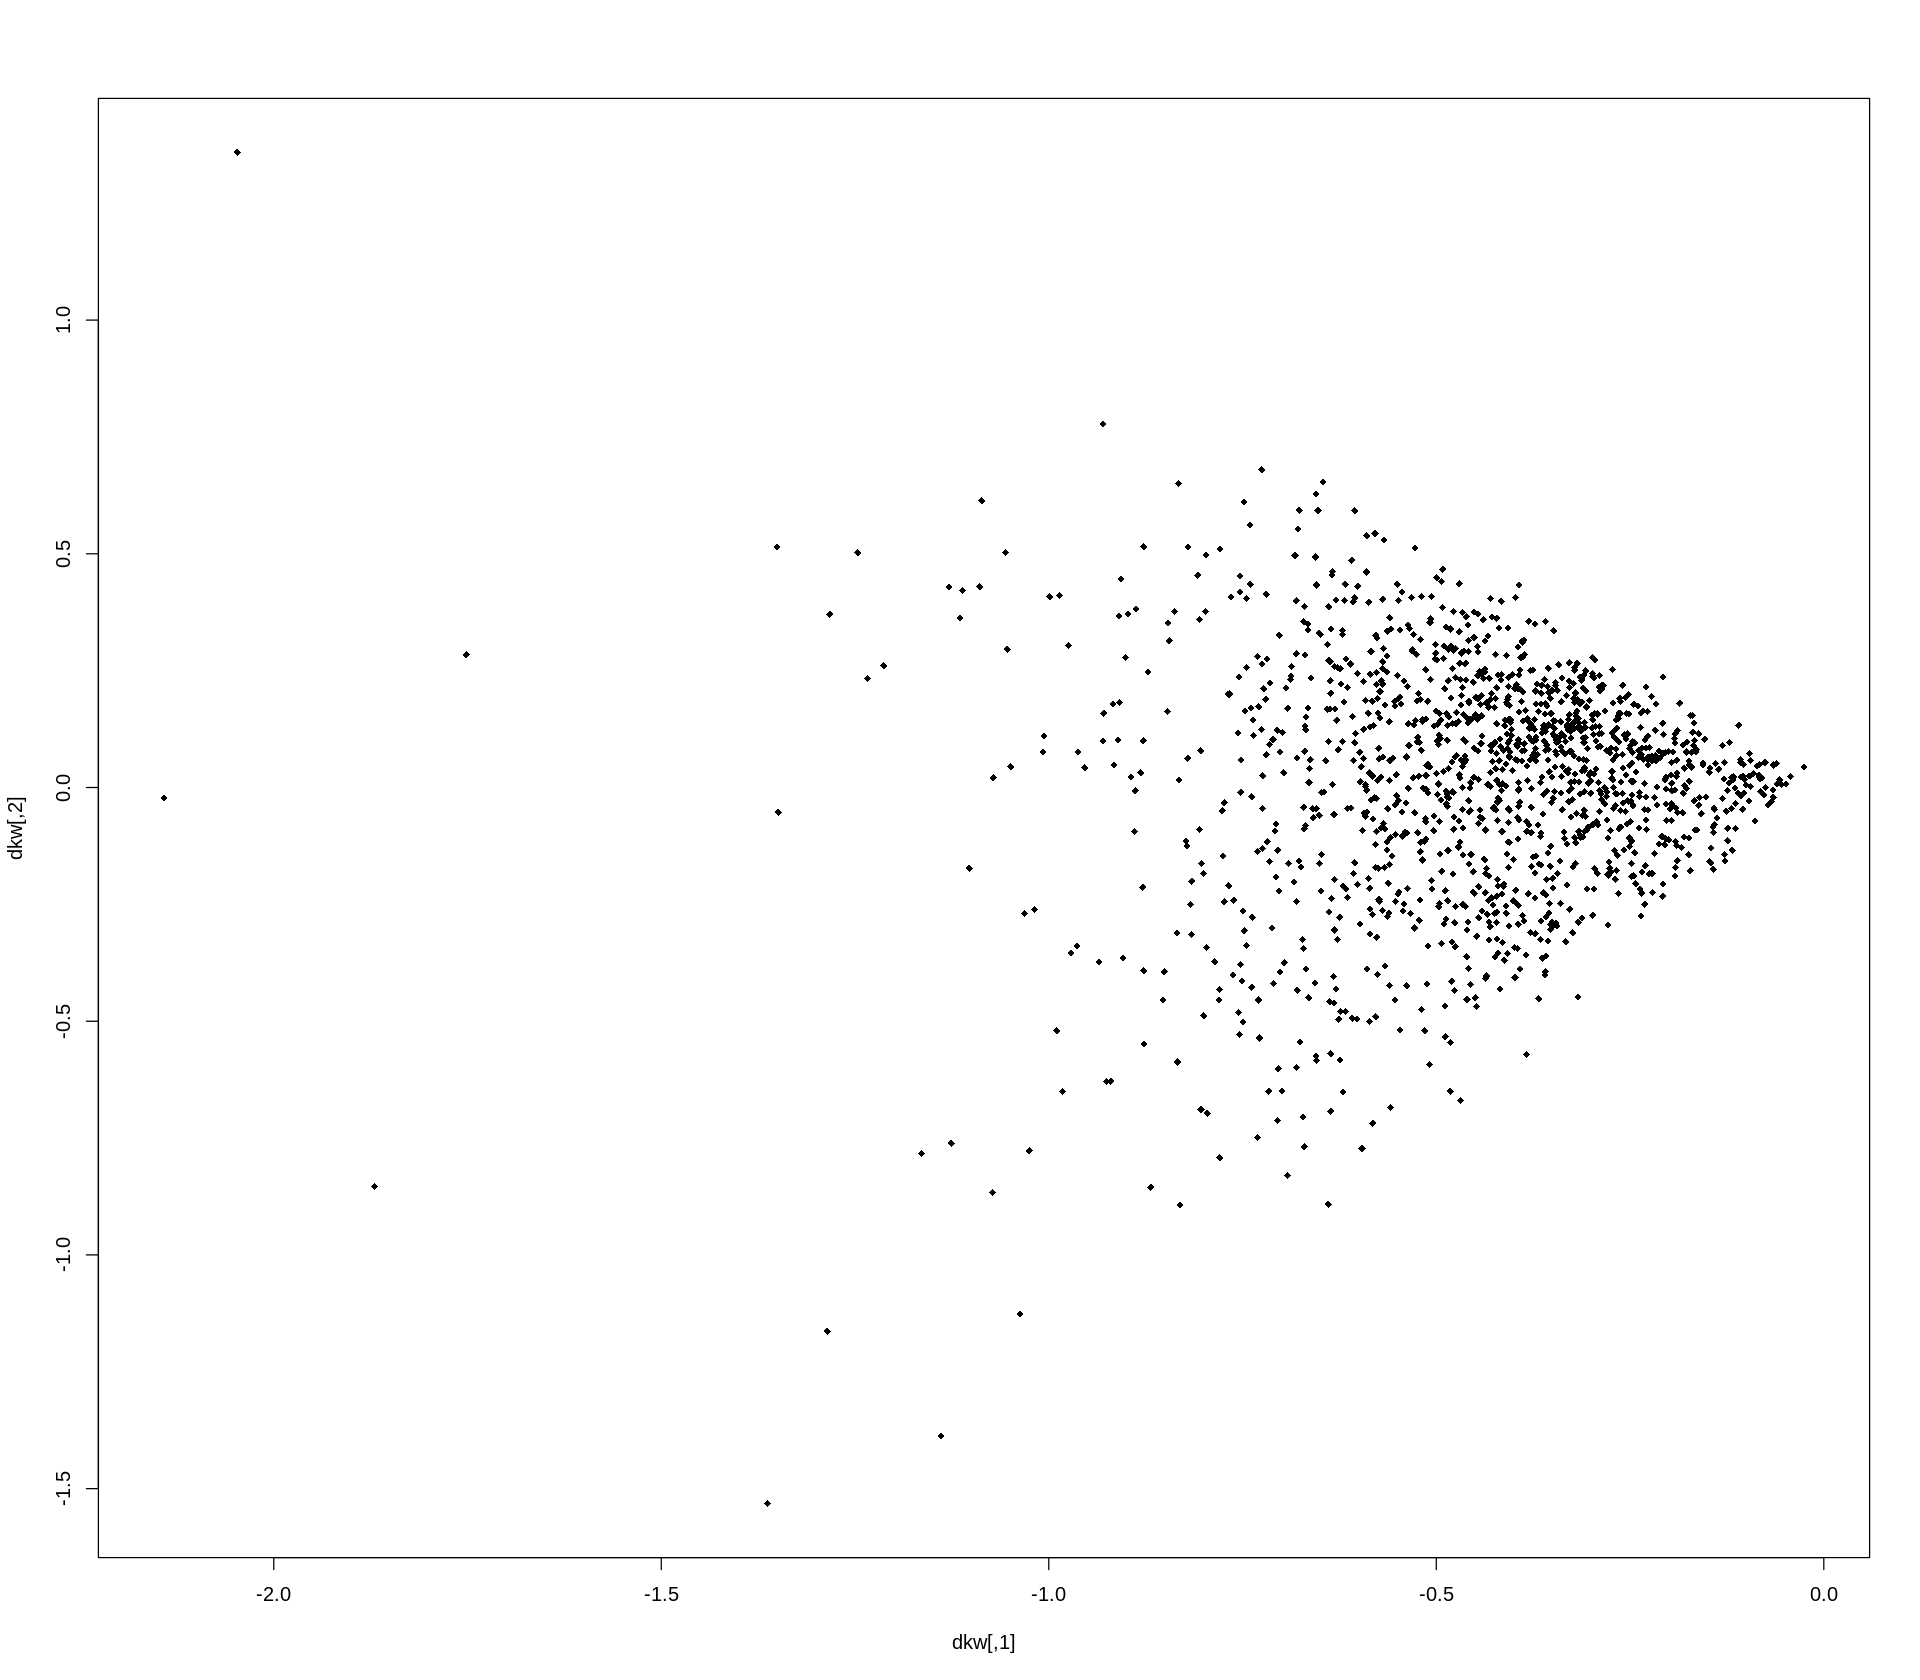

In [31]:
plot( dkw, pch=18, cex=0.8 )

### Evaluation of all the queries


In [32]:
#for each query compute the first k top results
top_results_lsa <- function(qry_id, df_qry, lsar, tdm, k){
  query_example <- df_qry[df_qry$index== qry_id,]$query
  q <- query( query_example, words )
  q_k <- lw_logtf(q) * ( 1-entropy(tdm) )
  q_kw <- t(q_k) %*% lsar$tk
  return (top(cosines(dkw, q_kw), k))
}

In [33]:
k =10
# the row i of the matrix results contains the first k retrieved docs for the query i
results = t(sapply(df_qry$index, top_results_lsa, df_qry, lsar, tdm, k))
#example of retrived docs for the first query
cat("First k retrieved docs for the first query:", results[1,],"\n")
cat("Relevant  docs for the first query:", df_rel[df_rel$qry_id== 1,]$rel_doc)

First k retrieved docs for the first query: 722 1299 1281 767 219 759 429 447 1364 573 
Relevant  docs for the first query: 28 35 38 42 43 52 65 76 86 150 189 192 193 195 215 269 291 320 429 465 466 482 483 510 524 541 576 582 589 603 650 680 711 722 726 783 813 820 868 869 894 1162 1164 1195 1196 1281

In [34]:
# compute the mean precision for all the queries
precisions = queries_precision(df_qry$index, results)
cat("Mean precision:", mean(precisions))

Mean precision: 0.3118421

In [35]:
# compute the mean recall for all the queries
recalls = queries_recall(df_qry$index, results)
cat("Mean recall:", mean(recalls))

Mean recall: 0.1166425

In [36]:
# compute the mean f1 score for all the queries
scores = queries_scores(df_qry$index, results)
cat("Mean f1 score:", mean(scores))

Mean f1 score: 0.267343

In [37]:
#compute the mean average precision
cat("MAP:", MAP(df_qry$index, results))

MAP: 0.07084095